# Hyperbolic Image Embeddings

Welcome to our second notebook for the ECCV 2022 Tutorial "[Hyperbolic Representation Learning for Computer Vision](https://sites.google.com/view/hyperbolic-tutorial-eccv22)"!


**Open notebook:** 
[![View on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://sites.google.com/view/hyperbolic-tutorial-eccv22/code?authuser=0)
[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://sites.google.com/view/hyperbolic-tutorial-eccv22/code?authuser=0)  

**Author:** Mina Ghadimi Atigh

In this tutorial, you will go through [Hyperbolic Image Embeddings](https://openaccess.thecvf.com/content_CVPR_2020/papers/Khrulkov_Hyperbolic_Image_Embeddings_CVPR_2020_paper.pdf), CVPR 2020 paper. The paper argues that hyperbolic spaces with negative curvature might often be more appropriate for learning the embedding of images. It shows that many image classification architectures, in particular the few-shot learning setting, can be easily modified to operate on hyperbolic embeddings, which in many cases also leads to improvements.

In this tutorial, you will go through the hyperbolic *Few-shot learning* task. Few-shot learning aims to classify new data given only a few training samples with supervised information. The few-shot learning task is formulated as N-way K-shot, in which N is the number of classes to classify and K is the number of samples given for each class.

Let's start with installing and importing libraries. Also, we set a manual seed using `set_seed`.

In [ ]:
!wget -q https://raw.githubusercontent.com/leymir/hyperbolic-image-embeddings/6633edbbeffd6d90271f0963852a046c64f407d6/examples/fewshot/networks/convnet.py
!pip install git+https://github.com/geoopt/geoopt.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/geoopt/geoopt.git to /tmp/pip-req-build-e0tswmk5
  Running command git clone -q https://github.com/geoopt/geoopt.git /tmp/pip-req-build-e0tswmk5
  Created wheel for geoopt: filename=geoopt-0.5.0-py3-none-any.whl size=90084 sha256=044fa65c82ae668be009942d919d326f2e3f3343af438796c4a8606197419901
  Stored in directory: /tmp/pip-ephem-wheel-cache-erk6ikgg/wheels/e9/b9/1f/4238e702b8889c5329cc24bb3c1d020ab33de17df8ee1e8da4
Successfully built geoopt


In [ ]:
## standard libraries
import numpy as np
import os
import PIL
from PIL import Image
from PIL import ImageEnhance
import random

## Imports for plotting
import matplotlib.pyplot as plt

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

## PyTorch Torchvision
import torchvision
from torchvision import transforms

## geoopt for hyperbolic  
import geoopt

## Neural network downloaded from paper's GitHub
from convnet import ConvNet

In [ ]:
# Function for setting the seed
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cpu


Throughout this tutorial, you will work with _CUB-200-2011_ Dataset. The CUB dataset consists of 11788 images of 200 bird classes. In the experiments, 100 classes are used for training, 50 for validation, and 50 for testing. The code starts with downloading the dataset first. 

Using the code, you can download the data to the path `data/cub`. Images will be saved in `data/cub/images`. Train, val, and test splits will be saved in `data/cub/split`. Also, there will be a `data/cub/classes.txt` file, containing the names of the 200 classes, which will be used for visualization.

In [ ]:
from IPython.display import clear_output 
%mkdir data
%mkdir data/cub
%cd data/cub
!wget -q -O tmp.tgz https://data.caltech.edu/tindfiles/serve/1239ea37-e132-42ee-8c09-c383bb54e7ff/
!tar -xzvf tmp.tgz
!rm tmp.tgz
!rm attributes.txt
%mkdir images
!mv CUB_200_2011/images/*/*.jpg images
!mv CUB_200_2011/classes.txt classes.txt
!rm -r CUB_200_2011
clear_output()

%mkdir split
%cd split
![ ! -f test.csv ] && wget -q https://raw.githubusercontent.com/leymir/hyperbolic-image-embeddings/master/examples/fewshot/data/cub/split/test.csv
![ ! -f val.csv ] && wget -q https://raw.githubusercontent.com/leymir/hyperbolic-image-embeddings/master/examples/fewshot/data/cub/split/val.csv
![ ! -f train.csv ] && wget -q https://raw.githubusercontent.com/leymir/hyperbolic-image-embeddings/master/examples/fewshot/data/cub/split/train.csv
%cd ../../..

/content/data/cub/split
/content


The next step is to handle data loader functions.

In [ ]:
# ROOT to the images and split, data files are available here.
ROOT_PATH = os.getcwd()
DATA_PATH = os.path.join(ROOT_PATH, "data/cub/")
IMAGE_PATH = os.path.join(DATA_PATH, "images")
SPLIT_PATH = os.path.join(DATA_PATH, "split")

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
transformtypedict = dict(
    Brightness=ImageEnhance.Brightness,
    Contrast=ImageEnhance.Contrast,
    Sharpness=ImageEnhance.Sharpness,
    Color=ImageEnhance.Color,
)


class ImageJitter(object):
    def __init__(self, transformdict):
        self.transforms = [(transformtypedict[k], transformdict[k]) for k in transformdict]

    def __call__(self, img):
        out = img
        randtensor = torch.rand(len(self.transforms))
        for i, (transformer, alpha) in enumerate(self.transforms):
            r = alpha * (randtensor[i] * 2.0 - 1.0) + 1
            out = transformer(out).enhance(r).convert("RGB")
        return out


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# This is for the CUB dataset, which does not support the ResNet encoder now
# It is notable, we assume the cub images are cropped based on the given bounding boxes
# The concept labels are based on the attribute value, which are for further use (and not used in this work)
class CUB(Dataset):
    def __init__(self, setname):
        txt_path = os.path.join(SPLIT_PATH, setname + ".csv")
        lines = [x.strip() for x in open(txt_path, "r").readlines()][1:]
        data = []
        label = []
        lb = -1
        self.wnids = []

        for l in lines:
            context = l.split(",")
            name = context[0]
            wnid = context[1]
            path = os.path.join(IMAGE_PATH, name)
            if wnid not in self.wnids:
                self.wnids.append(wnid)
                lb += 1

            data.append(path)
            label.append(lb)

        self.data = data
        self.label = label
        self.num_class = np.unique(np.array(label)).shape[0]

        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

        if setname == "train":
            self.transform = transforms.Compose([transforms.RandomResizedCrop(84),
                                                 ImageJitter(dict(Brightness=0.4, Contrast=0.4, Color=0.4)),
                                                 transforms.RandomHorizontalFlip(),
                                                 transforms.ToTensor(),
                                                 transforms.Normalize(np.array([0.485, 0.456, 0.406]),
                                                                      np.array([0.229, 0.224, 0.225])),
                                                 ])

        else:
            self.transform = transforms.Compose([transforms.Resize(84, interpolation=PIL.Image.BICUBIC),
                                                 transforms.CenterCrop(84),
                                                 transforms.ToTensor(),
                                                 normalize, ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        path, label = self.data[i], self.label[i]
        x = Image.open(path).convert("RGB")
        image = self.transform(Image.open(path).convert("RGB"))
        return image, label


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
class CategoriesSampler:
    def __init__(self, label, n_batch, n_cls, n_per):
        self.n_batch = n_batch
        self.n_cls = n_cls
        self.n_per = n_per

        label = np.array(label)
        self.m_ind = []
        for i in range(max(label) + 1):
            ind = np.argwhere(label == i).reshape(-1)
            ind = torch.from_numpy(ind)
            self.m_ind.append(ind)

    def __len__(self):
        return self.n_batch

    def __iter__(self):
        for i_batch in range(self.n_batch):
            batch = []
            classes = torch.randperm(len(self.m_ind))[: self.n_cls]
            for c in classes:
                l = self.m_ind[c]
                pos = torch.randperm(len(l))[: self.n_per]
                batch.append(l[pos])
            batch = torch.stack(batch).t().reshape(-1)
            yield batch


Exctract class names of the CUB dataset.

In [ ]:
classname_file = os.path.join(DATA_PATH, 'classes.txt')
class_dict = {}
with open(classname_file) as f:
    lines = f.readlines()
    for i, line in enumerate(lines):
        class_num = int(line.split(' ')[0])
        class_dict[class_num - 1] = line.split('.')[1].split('\n')[0].replace('_', ' ')

Before starting the main task, let's check how images from the dataset look like.

In [ ]:
# define a sample trainset
sample_trainset = CUB("train")

In [ ]:
# number of images to plot
NUM_IMAGES = 4
# Index of images to plot
indexes = random.sample(range(len(sample_trainset)), NUM_IMAGES)
images = [sample_trainset[idx][0] for idx in indexes]
labels = [sample_trainset[idx][1] for idx in indexes]

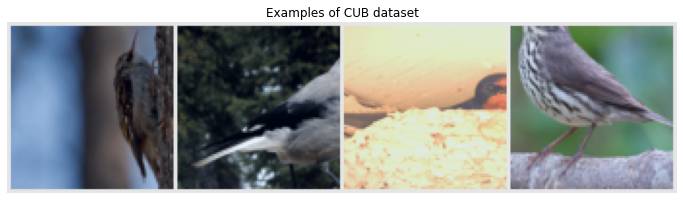

Belted Kingfisher  |  Western Gull      |  Hooded Merganser  |  Least Auklet    


In [ ]:
img_grid = torchvision.utils.make_grid(images, nrow=8, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(12,8))
plt.title("Examples of CUB dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()
print('  |  '.join(f'{class_dict[labels[j]]:16s}' for j in range(NUM_IMAGES)))

## Few Shot learning: Euclidean and Hyperbolic Space

First, we set the value of hyperparameters, assigned using `Config`. The hyperparameters are set for 5-way 1-shot task.

In [ ]:
class Config:
    def __init__(self, shot=1, lr=0.001, step=50, gamma=0.8, c=0.05, model="convnet", hyperbolic = True, dim=1600,
                 query=15, way=5, validation_way=5, temperature=1, dataset="CUB", lr_decay=True, max_epoch=200):
        
        self.lr = lr                                  # learning rate
        self.lr_decay = lr_decay                      # Boolean, if to perform learning rate scheduler
        self.step_size=step                           # Period of learning rate decay
        self.gamma = gamma                            # Multiplicative factor of learning rate decay
        self.dataset= dataset                         # Dataset name
        self.model = "convnet"                        # Name of Base Model
        self.temperature = temperature                # temperature used in calculating logits
        self.max_epoch=max_epoch                      # number of epochs

        self.c = c                                    # Curvature of the hyperbolic space
        self.hyperbolic = hyperbolic                  # Boolean, if it is hyperbolic or not
        self.dim = dim                                # dimenionality of the output vector

        self.shot = shot                              # Number of shots in Few shot learning task
        self.query = query                            #
        self.way = way                                # Number of ways in Few shot learning task
        self.validation_way = validation_way          # Number of ways in Few shot learning task for validation set


args = Config(dim=512, max_epoch = 5)

Split training and validation set based on the `Config` for few-shot learning.

In [ ]:
trainset = CUB("train")
train_sampler = CategoriesSampler(trainset.label, 100, args.way, args.shot + args.query)
train_loader = DataLoader(dataset=trainset, batch_sampler=train_sampler, num_workers=8, pin_memory=True)

valset = CUB("val")
val_sampler = CategoriesSampler(valset.label, 500, args.validation_way, args.shot + args.query)
val_loader = DataLoader(dataset=valset, batch_sampler=val_sampler, num_workers=8, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


Now, it's time to define the model. Structure of the model is based on "[Prototypical Networks for Few-shot Learning (ProtoNet)](https://papers.nips.cc/paper/2017/file/cb8da6767461f2812ae4290eac7cbc42-Paper.pdf)", NeurIPS 2017 paper. Hyperbolic Image Embeddings has picked ProtoNet because it is simple in general and simple to convert to hyperbolic geometry. ProtoNets use the so-called **prototype representation** of a class, which is defined as a **mean of the embedded support set of a class**. To generalize this concept to hyperbolic space, Euclidean mean is substituted by *hyperbolic average*.

Once the prototypes are calculated based on the average of data points, it's time to calculate the distance of the data points with the prototypes and perform classificatin based on the calculated logits. To calculate the distance in the hyperbolic space, *Hyperbolic distance* is used.

### Hyperbolic Average

Let's first define Hyperbolic average. Extension of Euclidean average to hyperbolic space is called *Einsterin midpoint*, which takes the most simple form in *Klein* coordinates.

\begin{align}
HypAve(x_1, ..., x_N) = \frac{\sum_{i=1}^N \gamma_i x_i}{\sum_{i=1}^N \gamma_i}
\end{align}

where $\gamma_i = \frac{1}{\sqrt{1-c\| x_i \|^2}}$ are the Lorentz factors. The Lorentz factors is implemented in `lorenz_factor` function.

HypAve is in Klein coordinates. Therefore it is necessary to transfer the points to the Klein model first and then project the calculated average onto the Poincare model.

Let $x_\mathbb{D}$ and $x_\mathbb{K}$ denote the coordinates of the same point in the Poincare and Klein models. To project the points between these models, the following equations are needed.

\begin{align}
x_\mathbb{D} = \frac{x_\mathbb{K}}{1 + \sqrt{1 - c\|x_\mathbb{K}\|^2}}
\end{align}

\begin{align}
x_\mathbb{K} = \frac{2x_\mathbb{D}}{1 + c\|x_\mathbb{D}\|^2}
\end{align}

These projecttions are implemented in `k2p` and `p2k` functions. Finally, $HypAve$ is implements in `poincare_mean` function.

In [ ]:
def lorenz_factor(x, *, c=1.0, dim=-1, keepdim=False):
    """
    Parameters
    ----------
    x : tensor
        point on Klein disk
    c : float
        negative curvature
    dim : int
        dimension to calculate Lorenz factor
    keepdim : bool
        retain the last dim? (default: false)

    Returns
    -------
    tensor
        Lorenz factor
    """
    return 1 / torch.sqrt(1 - c * x.pow(2).sum(dim=dim, keepdim=keepdim))

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Project a point from Klein model to Poincare model
def k2p(x, c):
    denom = 1 + torch.sqrt(1 - c * x.pow(2).sum(-1, keepdim=True))
    return x / denom

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Project a point from Poincare model to Klein model
def p2k(x, c):
    denom = 1 + c * x.pow(2).sum(-1, keepdim=True)
    return 2 * x / denom

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

def poincare_mean(x, dim=0, c=1.0):
    # To calculate the mean, another model of hyperbolic space named Klein model is used.
    # 1. point is projected from Poincare model to Klein model using p2k, output x is a point in Klein model
    x = p2k(x, c)
    # 2. mean is calculated
    lamb = lorenz_factor(x, c=c, keepdim=True)
    mean = torch.sum(lamb * x, dim=dim, keepdim=True) / torch.sum(lamb, dim=dim, keepdim=True)
    # 3. Mean is projected from Klein model to Poincare model
    mean = k2p(mean, c)
    return mean.squeeze(dim)

Now, it's time to define the model `ProtoNet`. Whether `args.hyperbolic` is *True* of *False*, the model can be Hyperbolic or Euclidean.


In [ ]:
class ProtoNet(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args

        # Base Model: ConvNet
        self.encoder = ConvNet(z_dim=args.dim)

        # If working in Hyperbolic Space
        if args.hyperbolic:
            self.manifold = geoopt.PoincareBall(c=args.c)

    def forward(self, data_shot, data_query):
        # 1. feed data to the model
        proto = self.encoder(data_shot)
        
        # Hyperbolic Space:
        if self.args.hyperbolic:
            # 2. encoder is Euclidean, so proto is in Euclidean space and should be projected to Hyperboolic space using exponential map
            proto = self.manifold.expmap0(proto)
            
            if self.training:
                proto = proto.reshape(self.args.shot, self.args.way, -1)
            else:
                proto = proto.reshape(self.args.shot, self.args.validation_way, -1)

            # 3. calculate prototypes based on mean of data
            proto = poincare_mean(proto, dim=0, c=self.manifold.c.item())
            
            # 4. query is projected to hyperbolic space too
            data_query = self.manifold.expmap0(self.encoder(data_query))
            
            # 5. Logits is calculated based on the Hyperbolic distance between data query and proto
            logits = (-self.manifold.dist(data_query[:, None, :], proto) / self.args.temperature)

        # Euclidean Space
        else:
            # 2. calculate prototypes based on mean of data
            if self.training:
                proto = proto.reshape(self.args.shot, self.args.way, -1).mean(dim=0)
            else:
                proto = proto.reshape(self.args.shot, self.args.validation_way, -1).mean(dim=0)
            
            # 3. Logits is calculated based on the Euclidean distance between data query and proto
            logits = (((self.encoder(data_query)[:, None, :] - proto)**2).sum(dim=-1) / self.args.temperature)
        return logits


model = ProtoNet(args).to(device)

Once the model is defined, it's time for the training loop. Let's first define *optimizer* and *learning rate scheduler*, alongside with functions to calculate accuracy and average.

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

if args.lr_decay:
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args.step_size, gamma=args.gamma)

In [ ]:
# Function to calculate the accuracy given logits and groundtruth labels
def count_acc(logits, label):
    pred = torch.argmax(logits, dim=1)
    if torch.cuda.is_available():
        return (pred == label).type(torch.cuda.FloatTensor).mean().item()
    else:
        return (pred == label).type(torch.FloatTensor).mean().item()
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Class defined to average the values passed to it
class Averager:
    def __init__(self):
        self.n = 0
        self.v = 0

    def add(self, x):
        self.v = (self.v * self.n + x) / (self.n + 1)
        self.n += 1

    def item(self):
        return self.v

#### Training loop
Next step is training the model.

In [ ]:
for epoch in range(1, args.max_epoch + 1):
    if args.lr_decay:
        lr_scheduler.step()
    model.train()
    
    tl = Averager()
    ta = Averager()

    label = torch.arange(args.way).repeat(args.query)
    if torch.cuda.is_available():
        label = label.type(torch.cuda.LongTensor)
    else:
        label = label.type(torch.LongTensor)

    for i, batch in enumerate(train_loader, 1):
        if torch.cuda.is_available():
            data, _ = [_.cuda() for _ in batch]
        else:
            data = batch[0]
        p = args.shot * args.way
        data_shot, data_query = data[:p], data[p:]
        logits = model(data_shot, data_query)
        loss = F.cross_entropy(logits, label)
        acc = count_acc(logits, label)
        if (i == 1) or (i == len(train_loader)): 
            print("epoch {}, train {}/{}, loss={:.4f} acc={:.4f}".format(epoch, i, len(train_loader), loss.item(), acc))
        
        tl.add(loss.item())
        ta.add(acc)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    tl = tl.item()
    ta = ta.item()

    model.eval()

    vl = Averager()
    va = Averager()

    label = torch.arange(args.validation_way).repeat(args.query)
    if torch.cuda.is_available():
        label = label.type(torch.cuda.LongTensor)
    else:
        label = label.type(torch.LongTensor)
    
    with torch.no_grad():
        for i, batch in enumerate(val_loader, 1):
            if torch.cuda.is_available():
                data, _ = [_.cuda() for _ in batch]
            else:
                data = batch[0]
            p = args.shot * args.validation_way
            data_shot, data_query = data[:p], data[p:]
            logits = model(data_shot, data_query)
            loss = F.cross_entropy(logits, label)
            acc = count_acc(logits, label)

            vl.add(loss.item())
            va.add(acc)

    vl = vl.item()
    va = va.item()
    print("epoch {}, val, loss={:.4f} acc={:.4f}".format(epoch, vl, va))

epoch 1, train 1/100, loss=1.5512 acc=0.3333
epoch 1, train 100/100, loss=1.1914 acc=0.5600
epoch 1, val, loss=1.5090 acc=0.3963
epoch 2, train 1/100, loss=1.8160 acc=0.3067
epoch 2, train 100/100, loss=1.7269 acc=0.3333
epoch 2, val, loss=1.3977 acc=0.4286
epoch 3, train 1/100, loss=1.8092 acc=0.2667
epoch 3, train 100/100, loss=1.9509 acc=0.3067
epoch 3, val, loss=1.3186 acc=0.4592
epoch 4, train 1/100, loss=1.1954 acc=0.4800
epoch 4, train 100/100, loss=1.4198 acc=0.4400
epoch 4, val, loss=1.3716 acc=0.4430
epoch 5, train 1/100, loss=1.9936 acc=0.2800
epoch 5, train 100/100, loss=1.0745 acc=0.6800
epoch 5, val, loss=1.3542 acc=0.4485


#### Testing function

Once the training is complete, it's time to see model's performance on the test split.

First, let's create test dataloader.

In [ ]:
test_set = CUB("test")
test_sampler = CategoriesSampler(test_set.label, 1000, args.validation_way, args.shot + args.query)
test_loader = DataLoader(test_set, batch_sampler=test_sampler, num_workers=8, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  "Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. "


In [ ]:
def compute_confidence_interval(data):
    """
    Compute 95% confidence interval
    :param data: An array of mean accuracy (or mAP) across a number of sampled episodes.
    :return: the 95% confidence interval for this data.
    """
    a = 1.0 * np.array(data)
    m = np.mean(a)
    std = np.std(a)
    pm = 1.96 * (std / np.sqrt(len(a)))
    return m, pm

In [ ]:
model.eval()

ave_acc = Averager()
test_acc_record = np.zeros((1000,))

label = torch.arange(args.validation_way).repeat(args.query)
if torch.cuda.is_available():
    label = label.type(torch.cuda.LongTensor)
else:
    label = label.type(torch.LongTensor)

# Testing loop
for i, batch in enumerate(test_loader, 1):
    if torch.cuda.is_available():
        data, _ = [_.cuda() for _ in batch]
    else:
        data = batch[0]
    k = args.validation_way * args.shot
    data_shot, data_query = data[:k], data[k:]

    logits = model(data_shot, data_query)
    acc = count_acc(logits, label)
    ave_acc.add(acc)
    test_acc_record[i - 1] = acc

m, pm = compute_confidence_interval(test_acc_record)
print("Test Acc {:.4f} + {:.4f}".format(m, pm))

Test Acc 0.4135 + 0.0063


As mentioned when defining `ProtoNet`, if `args.hyperbolic` is True, the model will be hyperbolic, Euclidean otherwise. To compare the performance of ProtoNet in hyperbolic and Euclidean manifolds, we train both of them for the same number of epochs. When training both models for $5$ epochs, the test accuracy of hyperbolic ProtoNet is around $41.35%$, while Euclidean ProtoNet results in an accuracy of $17.94%$. The paper also comes to a similar conclusion too. Based on the results provided in the paper, when training hyperbolic and Euclidean ProtoNet for $50$ epochs, the Euclidean version results in $51.31%$, while the hyperbolic one results in $64.02%$, which outperforms Euclidean one by more than $10%$.